# Pneumonia detection based on Chest X-Ray images on imbalanced data using just few steps and getting accuracy at least 94%

# Intro
Today we are going to apply CNN on X-Ray images of chest. Dataset is imbalanced (approx. 1:3), images may have different site and can have one or 3 color channels.

At start, we will preprocess our data in very simple and intuitive way (load, resize, convert to grayscale, create labels). Model is using grayscale images as for me it did not make too much sense to use X-Ray images as colorful images.

# Load libraries
We will use standard "data science" libraries including numpy, pandas, tensorflow, matplotlib and seaborn. Some additional libraries like glob and cv2 are used.

In [1]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load data
Our data consists of 3 folders - train, test, val. Train & test are used for modeling, validation will be used to check performance of model. Size of validation set is very small (16 cases).

We will also create dataframes so we can visualize distribution of cases in each set

This kind of load may not work well for large dataset as you will run out of memory. Data generator with flow_from_directory could be used, but it's really slow

In [2]:
path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'


# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

# Visualize distribution of cases
Now let's draw how are our datasets (im)balanced. You will find out, that training dataset is highly imbalanced, testing dataset is slightly imbalanced and validation dataset is balanced

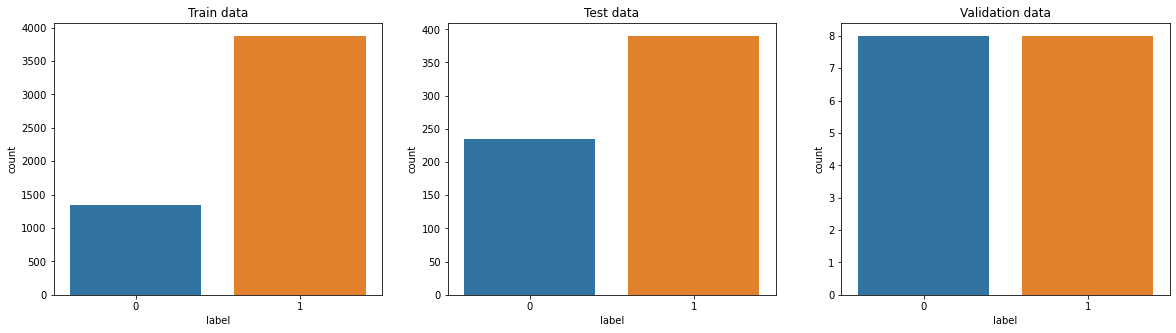

In [3]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

# Draw few samples of each case
In this step we simply want to see few cases of pneumonia and few cases of healthy people. For uninterested person it may not be easy to identify pneumonia on image. You will also notice that images does not have same dimension and must be rescaled to same width & height.

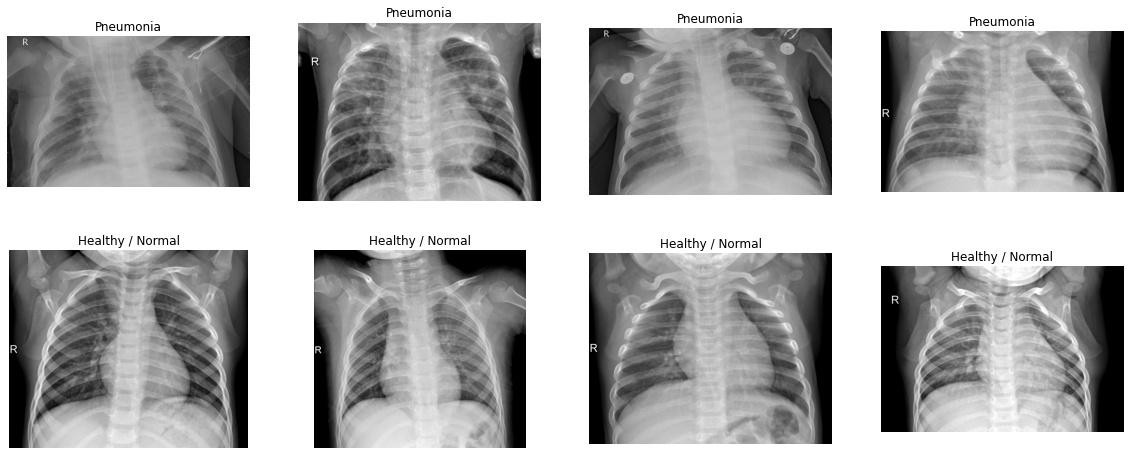

In [4]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Healthy / Normal')

# Data preprocessing
In following section we are going to prepare our data for modeling. Down-size of this technique is that you may run out of memory very quickly... but it's really fast!

To make it simple, define 2 functions.
* **process_data** - load image, resize it, convert to grayscale, normalize and reshape to dimension required for tensorflow
* **compose_dataset** - loop through images, generating 2 numpy arrays. First contains image itself as matrix, second contains label

In [5]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

Using our functions let's prepare our train, test and validation arrays from dataframes

In [6]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


**Image augmentation** is very important to make our model robust to unseen data. It takes each image and modify it slightly so simply said in each epoch, different image (generated from same) is sent to model for training.

In [7]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

It may be redudant step, but we are going to convert our 1D array of target labels into 2D array, changing classification from binary to categorical. During my tests, binary classification was slower and less accurate then categorical.

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Modelling
Simple sequential model is used, starting with 2 convolutional networks of kernel size (7,7) and max pooling with pool size (3,3), followed by 2 convolutional networks of kernel size (7,7) and same pool size and finalized by several repeating sets of 2 convolutional networks of kernel size (3,3) with max pooling and pool size (2,2)

Model bit slower, but getting above 92% accuracy that's great result!

In [9]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})

Epoch 1/100
1304/1304 [==============================] - 20s 16ms/step - loss: 0.6698 - accuracy: 0.5084 - val_loss: 0.5631 - val_accuracy: 0.7163
Epoch 2/100
1304/1304 [==============================] - 19s 15ms/step - loss: 0.3315 - accuracy: 0.8284 - val_loss: 0.2990 - val_accuracy: 0.8942
Epoch 3/100
1304/1304 [==============================] - 21s 16ms/step - loss: 0.2543 - accuracy: 0.8742 - val_loss: 0.3346 - val_accuracy: 0.8766
Epoch 4/100
1304/1304 [==============================] - 19s 15ms/step - loss: 0.2337 - accuracy: 0.8896 - val_loss: 0.3028 - val_accuracy: 0.8798
Epoch 5/100
1304/1304 [==============================] - 19s 15ms/step - loss: 0.2153 - accuracy: 0.9016 - val_loss: 0.2593 - val_accuracy: 0.9038
Epoch 6/100
1304/1304 [==============================] - 21s 16ms/step - loss: 0.2028 - accuracy: 0.9066 - val_loss: 0.2503 - val_accuracy: 0.8958
Epoch 7/100
1304/1304 [==============================] - 19s 15ms/step - loss: 0.1697 - accuracy: 0.9172 - val_loss: 0

# Evaluation
First, we will quickly check evolution of loss and accuracy over epochs and then draw confusion matrix on test dataa. Then how our validation set (16 cases) will work with trained model and compare real vs predicted label

## Draw loss on train vs test data evolution

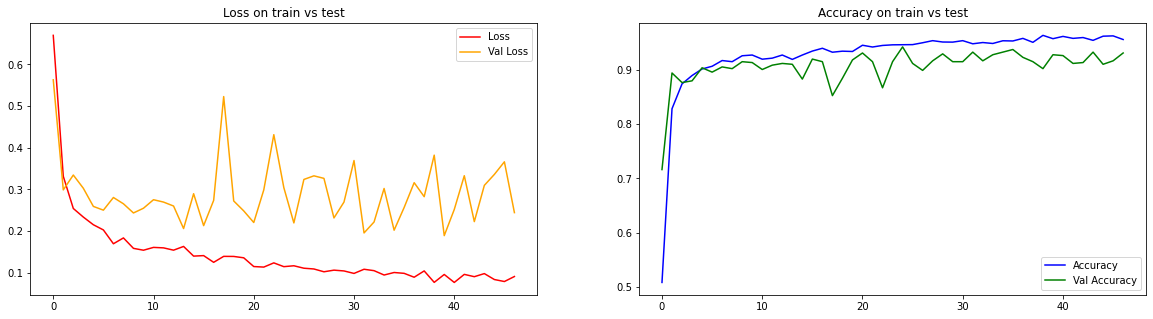

In [10]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

## Confusion matrix on test data

In [11]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

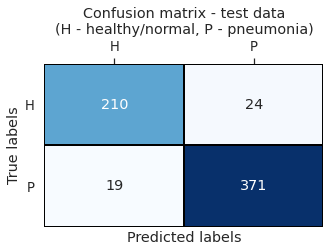

Classification report on test data
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       234
           1       0.94      0.95      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



In [12]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

It seems our algorithm is more likely predicting pneumonia, that is probably caused by imbalanced dataset and even setting class weights in tensorflow fit did not helped so much. We could increase weight for normal/healthy cases to get even better results.

## Validation data
First predict labels and get them to 1D array

In [13]:
y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)

Now let's show images, real & predicted labels

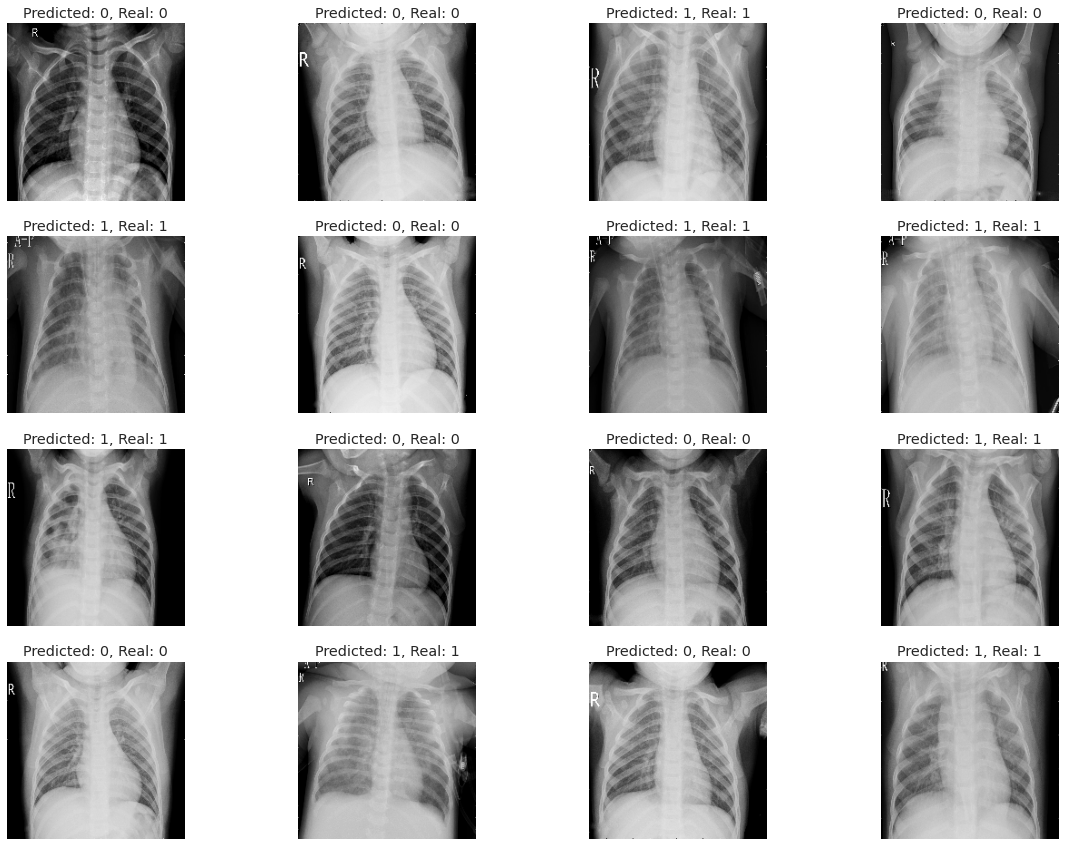

In [14]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]))  

**Wow**, not bad! Actually **great**! There is just one misclassification. Even doctor would have problems to classify it as correct, don't you think?. What about compiling model, creating web app and allow doctors to upload their X-Rays and get information what is likelihood patient has pneumonia? Good business plan ;)

### Thanks for checking my notebook, if you liked it, make sure to **vote** for for this notebook!